# Face Detection and Recognition CNN Models

Author: Luca Franceschi (u199149)

In this notebook we will try to construct two CNN models, one for face boundary detection and another for face recognition. The intention for the Coding Challenge 3 is to: with each image first detect if there is a face or not, in case there is, detect the boundaries. Then we can crop the image with the calculated boundaries and pass it to the recognition model to be able to recognize if the face exists in the dataset or is an impostor.

In [143]:
import torch
import scipy.io
import torch.jit
import numpy as np
from torch import nn
from PIL import Image
import torch.optim as optim
from matplotlib import ticker
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

from torch.utils.data import random_split
from torchvision.transforms.functional import get_image_size

In [144]:
# Hyperparameters
lr = 0.001                  # Learning rate
epochs = 10                 # Total number of epochs
batch_size = 32             # The sizes in which the dataset is split to feed the networks
det_resized = (224, 224)    # The normalized size of the images in the detection model
rec_resized = (60, 60)      # The normalized size of the images in the recognition model

# Other parameters
epoch_step = 1              # Frequency in which epoch losses are printed on training
images_path = './TRAINING/' # Relative path to the training dataset
target_matrix_path = ''     # Relative path to the "AGC_Challenge3_Training.mat" file

In [145]:
# Print if gpu acceleration is enabled
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


## Loading the target matrix

When loading the matrix we can import either the boundaries or the identity. 
- For the detection network we will import the Image name along with the boundaries. In case there is a face (or more) the first position in the boundaries will be the amount of faces in that image. In case there is no faces, that parameter will be 0 and the boundaries will be a "padding" of zeros. The imported data in this case will look like: ```[name, [#faces, x0, y0, x1, y1]]```, very similar as in previous labs. In case there are more than one face the first one in the matrix will be considered.
- For the recognition network... <font color="red">TODO</font>

In [146]:
def load_data(labels_path, labels_wanted='boundaries'):
    mat = scipy.io.loadmat(labels_path)['AGC_Challenge3_TRAINING'][0]
    data = []
    for entry in mat:
        key = entry[1][0]
        if (len(entry[2]) > 0):
            boundary = np.array(entry[2][0], dtype=np.int32)
            if (labels_wanted == 'boundaries'):
                data.append([key, boundary])
            elif (labels_wanted == 'identity'):
                data.append([key, entry[0][0][0]+1, boundary])
    return data

In [147]:
# mean and std extracted from the train_dataset part of AGC_Challenge3_TRAINING
# def compute_mean_std(dataset):
#     all_pixels = []
#     for image_path, _ in dataset:
#         with Image.open(images_path + image_path) as image:
#             image_array = np.array(image)
#             all_pixels.append(image_array)

#     all_images = np.stack(all_pixels, axis=0)

#     mean = np.mean(all_images, axis=(0, 1, 2)) / 255.0
#     std_dev = np.std(all_images, axis=(0, 1, 2)) / 255.0

#     return mean, std_dev

In [148]:
detection_data = load_data(target_matrix_path + 'AGC_Challenge3_Training.mat')
recognition_data = load_data(target_matrix_path + 'AGC_Challenge3_Training.mat', 'identity')

data_mean = [0.485, 0.456, 0.406]
data_std = [0.229, 0.224, 0.225]

## The Transforms

In [149]:
det_tr_transform = transforms.Compose([
    # transforms.Resize(300, 300),
    transforms.RandomResizedCrop(det_resized),
    # transforms.RandomHorizontalFlip(),
    # transforms.RandomRotation(20),
    transforms.ToTensor(),
    # transforms.Normalize(mean=train_mean, std=train_std)
    transforms.Normalize(mean=data_mean, std=data_std)
])

det_base_transform = transforms.Compose([
    transforms.Resize(det_resized),
    transforms.ToTensor(),
    transforms.Normalize(mean=data_mean, std=data_std)
])

rec_tr_transform = transforms.Compose([
    transforms.Resize(rec_resized),
    transforms.ToTensor(),
    transforms.Normalize(mean=data_mean, std=data_std)
])

rec_val_transform = rec_tr_transform

## The Convolutional Neural Network Class

In [150]:
class CNN(nn.Module):
    def __init__(self, cnn_layers, fc_layers, type):
        super().__init__()
        self.flatten = nn.Flatten()
        self.cnn_layers = cnn_layers
        self.fc_layers = fc_layers
        self.cnn_type = type

    def forward(self, data):
        output = self.cnn_layers(data)
        output = self.flatten(output) # before linear layer !!!
        output = self.fc_layers(output)
        return output

    def fit(self, training_data, loss_fn, optimizer: optim.Optimizer):
        self.train()
        total_loss = 0.0

        for batch_data, target in training_data:
            batch_data = batch_data.to(device)
            target = target.to(device)

            optimizer.zero_grad()

            output = self.forward(batch_data)
            if self.cnn_type == 'detection':
                pass
            elif self.cnn_type == 'recognition':
                print(target)
                target = target.type(torch.long)
            loss = loss_fn(output, target)

            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        return total_loss / len(training_data)

    def evaluate(self, validation_data, loss_fn):
        self.eval()
        total_loss = 0.0

        for batch_data, target in validation_data:
            batch_data = batch_data.to(device)
            target = target.to(device)
            
            output = self.forward(batch_data)
            loss = loss_fn(output, target)

            total_loss += loss.item()

            # Compute accuracy
            # _, predicted = torch.max(output, 1)
            # total_predictions += labels.size(0)
            # correct_predictions += (predicted == labels).sum().item()

        # average_loss = total_loss / len(validation_data)
        # accuracy = correct_predictions / total_predictions

        return total_loss / len(validation_data)

    def predict(self, test_image):
        self.eval()
        with torch.inference_mode(mode=True):
            test_image = test_image.convert('RGB')
            w, h = get_image_size(test_image)
            if self.cnn_type == 'detection':
                test_image = det_base_transform(test_image)
                # test_image = torch.tensor(test_image, dtype=torch.float32)
                output = self.forward(test_image.unsqueeze(0))[0]
                # print(output)
                # output = [output[0], output[1]*w/det_resized[0], output[2]*h/det_resized[1], output[3]*w/det_resized[0], output[4]*h/det_resized[1]]
                output = [output[0]*w/det_resized[0], output[1]*h/det_resized[1], output[2]*w/det_resized[0], output[3]*h/det_resized[1]]
                print(output)
                return output
            elif self.cnn_type == 'recognition':
                test_image = rec_val_transform(test_image)
                output = self.forward(test_image.unsqueeze(0))
                output = torch.argmax(output)-1
                print(output)
                return output
                

## The Detection Model

### The Data

In [48]:
class DetectionData(Dataset):
    # the data is in the form [img_name, boundaries]
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_name, label = self.data[idx]
        with Image.open(images_path + image_name) as image:
            # Apply transformations if specified
            image = image.convert('RGB')
            w, h = get_image_size(image)
            if self.transform:
                image = self.transform(image)
            # image = torch.tensor(image, dtype=torch.float32)

            # label = [label[0], label[1]/w*det_resized[0], label[2]/h*det_resized[1], label[3]/w*det_resized[0], label[4]/h*det_resized[1]]
            label = [label[0]/w*det_resized[0], label[1]/h*det_resized[1], label[2]/w*det_resized[0], label[3]/h*det_resized[1]]
            label = torch.tensor(label, dtype=torch.float32)
            label = torch.flatten(label)
            return image, label

In [49]:
# transforms son copiados, revisar
# calcular valores de mean y std del dataset para cada channel
# o las de imagenet
# flipping, cambios de colores, grayscale
# contraste de saturacion 
# color spaces
################

det_train_data, det_val_data, det_test_data = random_split(detection_data, [0.89, 0.1, 0.01], generator=torch.Generator().manual_seed(42))

# train_mean, train_std = compute_mean_std(det_train_data)

train_dataset = DetectionData(det_train_data, det_tr_transform)
val_dataset = DetectionData(det_val_data, det_base_transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

### The Layers

In [50]:
detection_cnn_layers = nn.Sequential(
    nn.Conv2d(3, 8, kernel_size=3, stride=1, padding=1),
    nn.BatchNorm2d(8),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2, stride=2),

    nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1),
    nn.BatchNorm2d(16),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2, stride=2),

    nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2, stride=2)
)
detection_fc_layers = nn.Sequential(
    nn.Linear(25088, 16),
    nn.ReLU(inplace=True),
    nn.Linear(16, 4)
)

### The Training Loop

In [51]:
detection = CNN(detection_cnn_layers, detection_fc_layers, 'detection').to(device)
print(detection)

CNN(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (cnn_layers): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layers): Sequential(
    (0): Linear(in_features=25088, out_features=16, bias=True)
 

In [52]:
print(sum(p.numel() for p in detection.parameters()))

407636


In [53]:
# train loop as train and then test
loss = nn.MSELoss()
optimizer = optim.Adam(detection.parameters(), lr=lr)

det_tr_losses = []
det_val_losses = []
for epoch in range(epochs):
    epoch_loss = 0
    det_tr_losses.append(detection.fit(train_loader, loss, optimizer))
    det_val_losses.append(detection.evaluate(val_loader, loss))

    if epoch % epoch_step == 0:
        print(f'Epoch {epoch} has loss {det_val_losses[epoch]}')

Epoch 0 has loss 5100.5224609375
Epoch 1 has loss 1096.9373779296875
Epoch 2 has loss 733.8440551757812
Epoch 3 has loss 731.6389770507812
Epoch 4 has loss 691.5187683105469
Epoch 5 has loss 672.9169921875
Epoch 6 has loss 644.6083374023438
Epoch 7 has loss 626.6275329589844
Epoch 8 has loss 641.1612854003906
Epoch 9 has loss 627.1818542480469


### Plots

In [54]:
def loss_epoch_plot(losses, title='Loss vs training epochs', nbins='auto'):
    ax = plt.figure().gca()
    ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=nbins, integer=True))
    ax.spines['top'].set_color('white') 
    ax.spines['right'].set_color('white')

    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')

    x = np.linspace(1, len(losses)+1, len(losses), dtype=np.uint16)
    plt.plot(x, losses)
    
    plt.show()

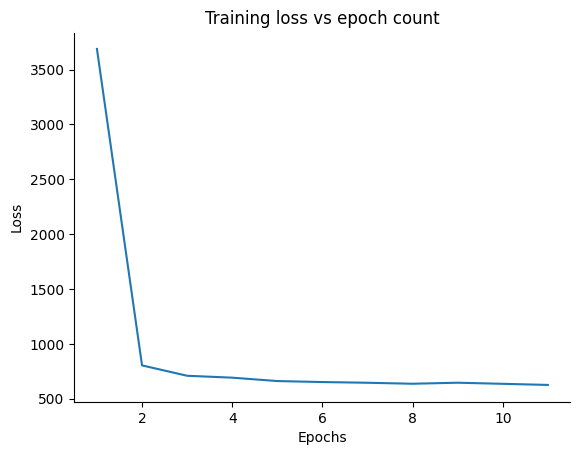

In [55]:
loss_epoch_plot(det_tr_losses, "Training loss vs epoch count")

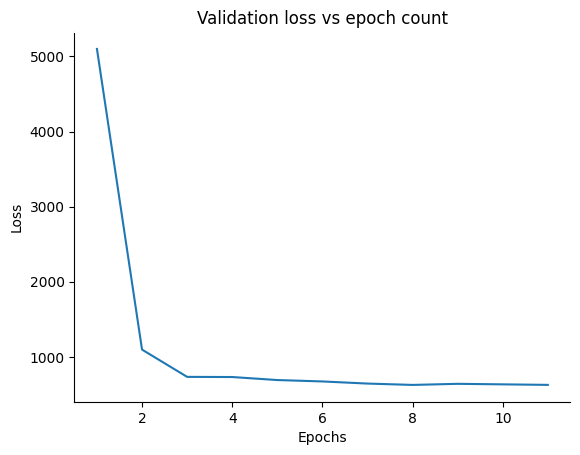

In [56]:
loss_epoch_plot(det_val_losses, "Validation loss vs epoch count")

### Testing

[ 42 208 430 596]
[tensor(145.4562), tensor(168.8120), tensor(380.5964), tensor(500.3972)]


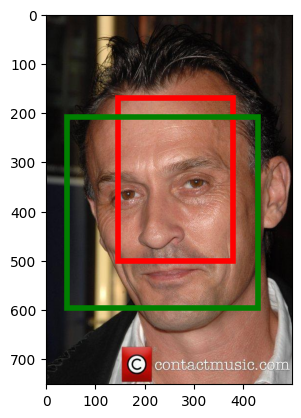

[153  65 339 251]
[tensor(157.8712), tensor(166.5542), tensor(369.0496), tensor(478.4253)]


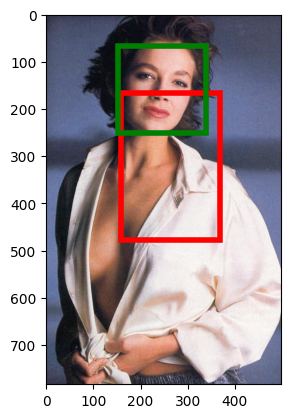

[378 118 691 431]
[tensor(329.5649), tensor(146.3932), tensor(723.4335), tensor(426.1481)]


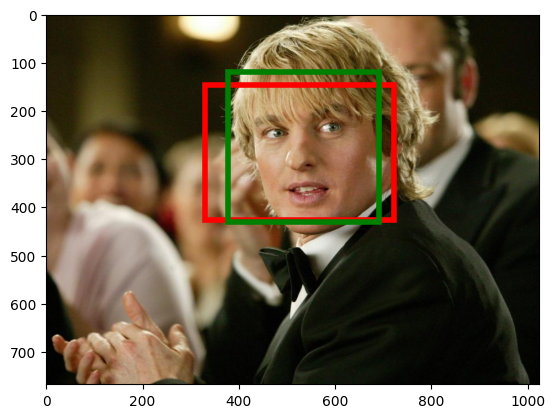

[ 96  18 199 121]
[tensor(98.0154), tensor(46.0838), tensor(214.2374), tensor(152.1384)]


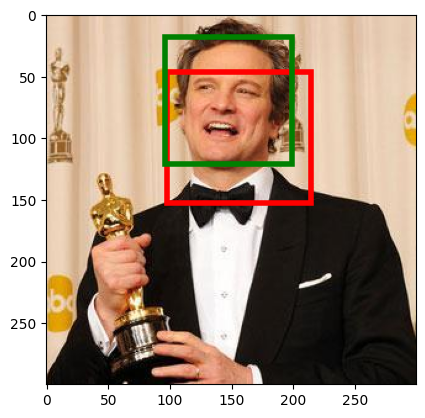

[218 303 548 633]
[tensor(230.3036), tensor(180.7018), tensor(462.4654), tensor(514.7814)]


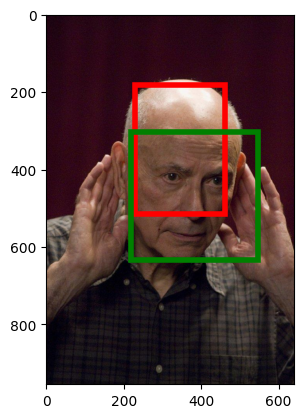

[218  88 352 222]
[tensor(220.5329), tensor(67.3590), tensor(543.2102), tensor(239.9027)]


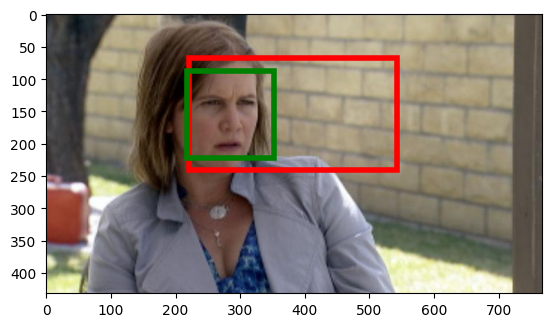

In [57]:
for image_name, target in det_test_data:
    with Image.open(images_path + image_name) as image:
        fig, ax = plt.subplots()
        ax.imshow(image)
        print(target)
        output = detection.predict(image)
        pred_fb = patches.Rectangle((output[0], output[1]), output[2]-output[0], output[3]-output[1], 
                               linewidth=4, edgecolor='red', facecolor='none')
        fb = patches.Rectangle((target[0], target[1]), target[2]-target[0], target[3]-target[1], 
                               linewidth=4, edgecolor='green', facecolor='none')
        ax.add_patch(pred_fb)
        ax.add_patch(fb)
        plt.show()

### Saving the model

In [58]:
detection_scripted = torch.jit.script(detection)
detection_scripted.save('detection_model.pt')

## The Recognition model

### The Data

In [151]:
class RecognitionData(Dataset):
    # the data is in the form [img_name, identity]
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_name, id, boundary = self.data[idx]
        with Image.open(images_path + image_name) as image:
            image = image.convert('RGB')
            image = image.crop(boundary)
            if self.transform:
                image = self.transform(image)
            id = torch.tensor(id, dtype=torch.float32)
            return image, id

In [152]:
rec_train_data, rec_val_data, rec_test_data = random_split(recognition_data, [0.89, 0.1, 0.01], generator=torch.Generator().manual_seed(42))

train_dataset2 = RecognitionData(rec_train_data, rec_tr_transform)
val_dataset2 = RecognitionData(rec_val_data, rec_val_transform)

train_loader2 = DataLoader(train_dataset2, batch_size=batch_size, shuffle=True)
val_loader2 = DataLoader(val_dataset2, batch_size=batch_size)

### The Layers

In [153]:
recognition_cnn_layers = nn.Sequential(
    nn.Conv2d(3, 8, kernel_size=3, stride=1, padding=1),
    nn.BatchNorm2d(8),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2, stride=2),

    nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1),
    nn.BatchNorm2d(16),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2, stride=2),

    nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2, stride=2)
)
recognition_fc_layers = nn.Sequential(
    nn.Linear(1568, 16),
    nn.ReLU(inplace=True),
    nn.Linear(16, 81),
    nn.Softmax()
)

### The Training Loop

In [154]:
recognition = CNN(recognition_cnn_layers, recognition_fc_layers, 'recognition').to(device)
print(recognition)

CNN(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (cnn_layers): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layers): Sequential(
    (0): Linear(in_features=1568, out_features=16, bias=True)
  

In [155]:
print(sum(p.numel() for p in recognition.parameters()))

32625


In [156]:
# va a sacar un vector y hacer argmax
# cross entropy con softmax + adam

loss2 = nn.CrossEntropyLoss()
optimizer2 = optim.Adam(recognition.parameters(), lr=lr)

In [157]:
rec_tr_losses = []
rec_val_losses = []
for epoch in range(epochs):
    epoch_loss = 0
    rec_tr_losses.append(recognition.fit(train_loader2, loss2, optimizer2))
    rec_val_losses.append(recognition.evaluate(val_loader2, loss2))

    if epoch % epoch_step == 0:
        print(f'Epoch {epoch} has loss {rec_val_losses[epoch]}')

tensor([40.,  0.,  0., 23., 29., 31., 55., 73., 21.,  5., 31., 66., 77.,  0.,
        75.,  4.,  0.,  0., 68.,  0., 14.,  6., 38.,  6.,  0., 59., 32., 31.,
        24., 62., 31., 11.])
tensor([ 0.,  7., 20.,  3., 66.,  0.,  5.,  0., 76., 40., 11., 25., 17., 17.,
        10.,  0.,  0.,  0., 47., 10., 53., 10., 34., 23., 13.,  4., 26.,  0.,
         0., 13.,  6., 53.])
tensor([43., 73., 15., 51.,  0.,  0., 74., 27., 38., 69.,  0., 52.,  0., 11.,
        32., 30., 17., 31.,  0.,  0.,  0., 72.,  3.,  0.,  0., 14., 48., 77.,
        45., 14.,  3., 18.])
tensor([ 0.,  8.,  0., 73.,  4., 18., 14., 24., 60., 30.,  0.,  0.,  0., 78.,
        29., 17.,  0., 32., 32.,  4., 31., 29., 69., 12., 71.,  0., 25., 13.,
        29., 41., 17.,  0.])
tensor([43., 51., 29.,  0., 61., 27.,  5., 50., 67., 26., 55., 10., 56., 23.,
        22.,  0., 58.,  0.,  0., 23., 61., 41., 12., 35., 12., 36., 19., 62.,
         0., 45., 59., 21.])
tensor([14., 18., 64., 10.,  6., 63., 47.,  0.,  3., 63.,  7., 14.,  3., 58

IndexError: Target 81 is out of bounds.

### Plots

In [ ]:
loss_epoch_plot(rec_tr_losses, "Training loss vs epoch count")

In [ ]:
loss_epoch_plot(rec_val_losses, "Validation loss vs epoch count")

### Testing

In [ ]:
for image_name, id, boundary in rec_test_data:
    with Image.open(images_path + image_name) as image:
        image = image.convert('RGB')
        image = image.crop(boundary)
        print(id)
        output = recognition.predict(image)
        print(output)